In [ ]:


# ------------------------------------------------------------
# 🧹 1. Load and Clean Data
# ------------------------------------------------------------


# ------------------------------------------------------------
# 🧠 2. Split Dataset
# ------------------------------------------------------------


# ------------------------------------------------------------
# 🧩 3. TF-IDF Vectorization (Improved)
# ------------------------------------------------------------


# ------------------------------------------------------------
# ⚙️ 4. Model Training with Hyperparameter Tuning
# ------------------------------------------------------------

# ------------------------------------------------------------
# 📊 5. Evaluation
# ------------------------------------------------------------



# Importing necessary libraries

In [1]:
#import necessary libraries
import pandas as pd
import unicodedata
from datasets import load_dataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

/Users/brianrono/anaconda3/envs/dev_env_clean/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Load and Clean Data

In [2]:
# Loading datasets 

datasets_to_load = [
    ('wikitext', 'wikitext-103-raw-v1', 'en'),
    ('swahili_news', None, 'sw'),
    ('cfilt/iitb-english-hindi', None, 'hi'),
    ('projecte-aina/ES-AN_Parallel_Corpus', None, 'es-an'),
]

dfs = []

for dataset_name, config, lang in datasets_to_load:
    try:
        if config:
            dataset = load_dataset(dataset_name, config, split='train[:5000]')
        else:
            dataset = load_dataset(dataset_name, split='train[:5000]')

        if dataset_name == 'cfilt/iitb-english-hindi':
            df_hi = pd.DataFrame({'text': [t['hi'] for t in dataset['translation']], 'lang': 'hi'})
            dfs.append(df_hi)

        elif dataset_name == 'projecte-aina/ES-AN_Parallel_Corpus':
            df_es = pd.DataFrame({'text': dataset['es'], 'lang': 'es'})
            df_an = pd.DataFrame({'text': dataset['an'], 'lang': 'an'})
            dfs.extend([df_es, df_an])

        else:
            text_col = None
            for col in ['text', 'content', 'sentence', 'article', 'source_text']:
                if col in dataset.column_names:
                    text_col = col
                    break
            if not text_col:
                text_col = dataset.column_names[0]

            df_lang = pd.DataFrame({'text': dataset[text_col], 'lang': lang})
            dfs.append(df_lang)

    except Exception as e:
        print(f" Failed to load {dataset_name}: {e}")

# Combine and shuffle
df = pd.concat(dfs, ignore_index=True)
df = df.dropna(subset=['text'])
df = df[df['text'].str.strip().astype(bool)]
df['text'] = df['text'].apply(lambda x: unicodedata.normalize("NFKC", str(x)))

# Balance classes
min_count = df['lang'].value_counts().min()
df = df.groupby('lang').sample(min_count, random_state=42)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Data prepared:")
print(df['lang'].value_counts())

Data prepared:
lang
es    3227
an    3227
sw    3227
en    3227
hi    3227
Name: count, dtype: int64


# 2. Split Dataset

In [3]:
train, temp = train_test_split(df, test_size=0.2, stratify=df['lang'], random_state=42)
val, test = train_test_split(temp, test_size=0.5, stratify=temp['lang'], random_state=42)

# 3. TF-IDF Vectorization

In [4]:
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 5), max_features=20000)
X_train = vectorizer.fit_transform(train['text'])
X_val = vectorizer.transform(val['text'])
X_test = vectorizer.transform(test['text'])

y_train, y_val, y_test = train['lang'], val['lang'], test['lang']

# 4. Model Training with Hyperparameter Tuning

In [5]:
param_grid = {'alpha': [0.1, 0.3, 0.5, 1.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

clf = grid.best_estimator_
print(f" Best model: {clf}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Best model: MultinomialNB(alpha=0.1)


# 5. Evaluation


Validation Accuracy: 0.9944203347799132

Test Accuracy: 0.993184634448575

Classification Report:
               precision    recall  f1-score   support

          an       1.00      0.98      0.99       323
          en       0.99      1.00      1.00       323
          es       0.98      1.00      0.99       322
          hi       1.00      0.99      1.00       323
          sw       1.00      1.00      1.00       323

    accuracy                           0.99      1614
   macro avg       0.99      0.99      0.99      1614
weighted avg       0.99      0.99      0.99      1614



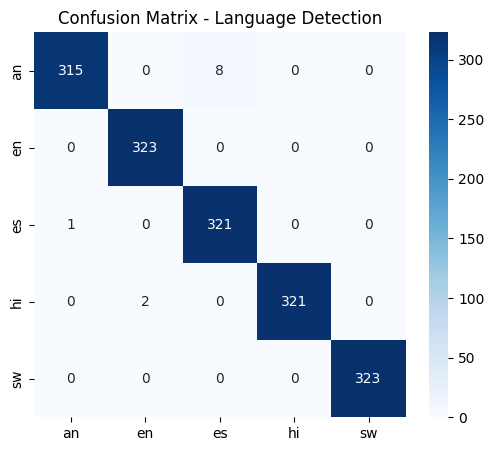

In [6]:
val_pred = clf.predict(X_val)
print("\nValidation Accuracy:", accuracy_score(y_val, val_pred))

test_pred = clf.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, test_pred))
print("\nClassification Report:\n", classification_report(y_test, test_pred))

cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix - Language Detection")
plt.show()

# 6. TEST ON UNSEEN TEXTS

Model Predictions on Unseen Texts:

Text: Habari yako rafiki yangu
 Predicted: sw (Confidence: 1.00)

Text: Buenos días, ¿cómo estás?
 Predicted: es (Confidence: 0.67)

Text: आज मौसम बहुत अच्छा है
 Predicted: hi (Confidence: 1.00)

Text: Good evening, hope you're fine
 Predicted: en (Confidence: 1.00)

Text: Ola chent aduya
 Predicted: an (Confidence: 1.00)

Text: Karibu nyumbani, mgeni
 Predicted: sw (Confidence: 1.00)

Text: Mi casa es tu casa
 Predicted: es (Confidence: 0.65)

Text: Namaste duniya
 Predicted: an (Confidence: 0.45)

Text: This is a test sentence
 Predicted: en (Confidence: 1.00)

Text: Bona nueit, como t’estás?
 Predicted: an (Confidence: 0.87)

Text: I'm a Kenyan.
 Predicted: sw (Confidence: 1.00)



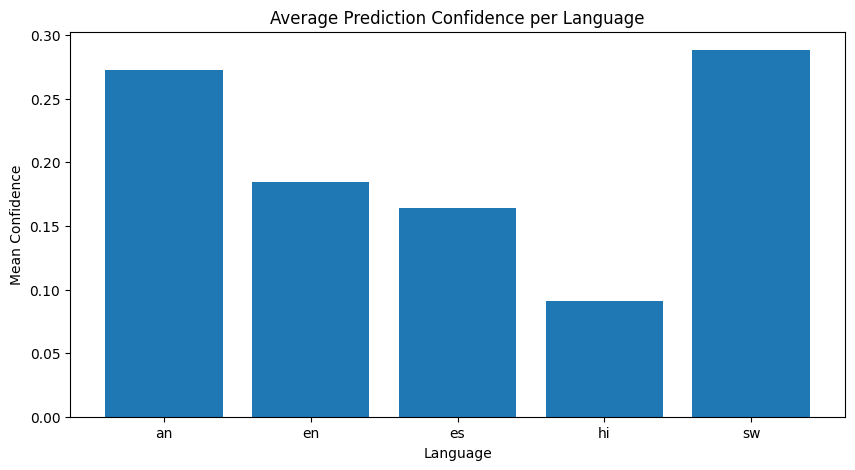

In [8]:
# Define custom unseen samples
unseen_texts = [
    "Habari yako rafiki yangu",        # Swahili
    "Buenos días, ¿cómo estás?",       # Spanish
    "आज मौसम बहुत अच्छा है",           # Hindi
    "Good evening, hope you're fine",  # English
    "Ola chent aduya",                 # Aragonese (similar to Spanish)
    "Karibu nyumbani, mgeni",          # Swahili
    "Mi casa es tu casa",              # Spanish
    "Namaste duniya",                  # Hindi/English mix
    "This is a test sentence",         # English
    "Bona nueit, como t’estás?",        # Aragonese dialect
    "I'm a Kenyan."
]

# Transform using trained TF-IDF vectorizer
X_unseen = vectorizer.transform(unseen_texts)

# Predict with best model
predictions = clf.predict(X_unseen)
probs = clf.predict_proba(X_unseen)

# Display predictions
print("Model Predictions on Unseen Texts:\n")
for text, pred, prob in zip(unseen_texts, predictions, probs):
    top_conf = max(prob)
    print(f"Text: {text}\n Predicted: {pred} (Confidence: {top_conf:.2f})\n")

# Optional: visualize prediction confidence per language
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
langs = clf.classes_
plt.bar(langs, np.mean(probs, axis=0))
plt.title("Average Prediction Confidence per Language")
plt.xlabel("Language")
plt.ylabel("Mean Confidence")
plt.show()